# Vacuum in the squeezed hierarchy

In [1]:
from functools import partial
import pickle

import numpy as np
from scipy.special import factorial, sinc
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier

In [2]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [3]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(nmax):
    '''Return vacuum density matrix

    Parameters
    ----------
    nmax : int
        The n of the largest fock-state |n> in the truncation.

    '''
    ket = np.zeros(nmax + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def make_squeezed_state_vec(r, mu, N, normalized=True):
    r'''Make a truncated squeezed-state vector.

    The squeezed-state vector is :math:`S(r,\mu)|0\rangle`. The truncated
    vector is renormalized by default.

    Parameters
    ----------
    N: positive integer
        The dimension of the truncated Hilbert space, basis {0, ..., N-1}
    r: real number
        Squeezing amplitude
    mu: real number
        Squeezing phase
    normalized: boolean
        Whether or not the truncated vector is renormalized

    Returns
    -------
    numpy.array
        Squeezed-state vector in the truncated Hilbert space, represented in the
        number basis

    '''
    ket = np.zeros(N, dtype=np.complex)
    for n in range(N//2):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket) if normalized else ket

def sqz_rho(r, mu, n):
    return rho_from_ket(make_squeezed_state_vec(r, mu, n + 1))

In [4]:
def make_plot_data(r, mu, factories, xi_fn, times, rho0):
    n_maxs = list(factories.keys())
    integrators = {n_max: factory.make_uncond_integrator(xi_fn, Id, sm, zero, r, mu)
                  for n_max, factory in factories.items()}
    field_rho0s = {n_max: sqz_rho(-r, mu, n_max) for n_max in n_maxs}
    solns = {n_max: integrator.integrate(rho0, times) for n_max, integrator in integrators.items()}
    phys_solns = {n_max: solns[n_max].get_phys_soln(field_rho0s[n_max]) for n_max in n_maxs}
    Pe_expts = {n_max: solns[n_max].get_expectations((Id + sz)/2, field_rho0s[n_max]) for n_max in n_maxs}
    return phys_solns, Pe_expts

In [5]:
def plot_Pe(times, n_maxs, Pe_expts, ax):
    for n_max in n_maxs:
        ax.plot(times, Pe_expts[n_max], label=str(n_max))
    ax.legend()

In [6]:
def plot_exp_decay(times, n_maxs, Pe_expts, vac_Pe_expt, ax):
    for n_max in n_maxs:
        ax.semilogy(times, Pe_expts[n_max], label=str(n_max))
    ax.semilogy(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
    ax.legend()

In [7]:
def plot_difference(times, n_maxs, Pe_expts, vac_Pe_expt, ax):
    for n_max in n_maxs:
        ax.plot(times, Pe_expts[n_max] - vac_Pe_expt, label=str(n_max))

In [8]:
times = np.linspace(0, 1, 2**8 + 1)
rho0 = (Id + sz)/2

In [9]:
vac_integrator = integ.UncondLindbladIntegrator([sm], zero)
vac_soln = vac_integrator.integrate(rho0, times)
vac_Pe_expt = vac_soln.get_expectations((Id + sz)/2)

/Users/azaghal/anaconda3/lib/python3.7/site-packages/sparse/_coo/common.py:1218: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.numpy_support', please update to use 'numba.np.numpy_support' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  locals={'data_curr': numba.numpy_support.from_dtype(dtr)})


In [10]:
r = np.log(1.5)
mu = 0
n_maxs = np.arange(1, 13)
factories = {n_max: hier.HierarchyIntegratorFactory(2, n_max)
             for n_max in n_maxs}
xi_fn = partial(xi_rect, a=0, b=1)

In [11]:
def gen_save_load_data(fname, data_gen_method, data_gen_params=None, data_gen_kwargs=None, overwrite=False):
    '''Get the data returned by the generating method, running the method only if the data isn't already available.

    If the given filename exists, load and return the data from that file. Otherwise generate the data using the
    supplied method and save and return it.

    Useful for notebooks you imagine running multiple times, but where some of the data is expensive to generate
    and you want to save it to disk to be reloaded for future sessions.

    '''
    if data_gen_params is None:
        data_gen_params = ()
    if data_gen_kwargs is None:
        data_gen_kwargs = {}
    try:
        with open(fname, 'xb' if not overwrite else 'wb') as f:
            data = data_gen_method(*data_gen_params, **data_gen_kwargs)
            pickle.dump(data, f)
    except FileExistsError:
        print('Data already exist.')
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    return data

In [12]:
solns, Pe_expts = gen_save_load_data('vacuum_plot_data.pickle', make_plot_data, (r, mu, factories, xi_fn, times, rho0))

Data already exist.


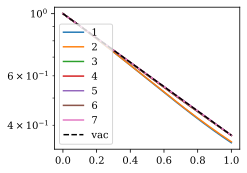

In [13]:
with plt.style.context('paper.mplstyle'):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    plot_exp_decay(times, n_maxs[:7], Pe_expts, vac_Pe_expt, ax)
    plt.tight_layout()

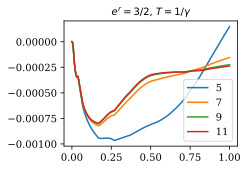

In [14]:
with plt.style.context('paper.mplstyle'):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    ax.set_title(r'$e^r=3/2$, $T=1/\gamma$')
    plot_difference(times, n_maxs[4::2], Pe_expts, vac_Pe_expt, ax)
    ax.legend()
    plt.tight_layout()

In [15]:
solns2, Pe_expts2 = gen_save_load_data('vacuum_plot_data2.pickle', make_plot_data, (np.log(2), mu, factories, xi_fn, times, rho0))

Data already exist.


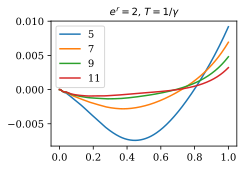

In [16]:
with plt.style.context('paper.mplstyle'):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    ax.set_title(r'$e^r=2$, $T=1/\gamma$')
    plot_difference(times, n_maxs[4::2], Pe_expts2, vac_Pe_expt, ax)
    ax.legend()
    plt.tight_layout()

In [17]:
solns3, Pe_expts3 = gen_save_load_data('vacuum_plot_data3.pickle', make_plot_data, (np.log(3), mu, factories, xi_fn, times, rho0))

Data already exist.


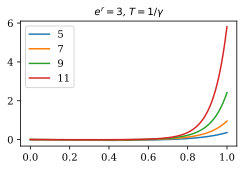

In [18]:
with plt.style.context('paper.mplstyle'):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    ax.set_title(r'$e^r=3$, $T=1/\gamma$')
    plot_difference(times, n_maxs[4::2], Pe_expts3, vac_Pe_expt, ax)
    ax.legend()
    plt.tight_layout()

In [19]:
timesT2 = np.linspace(0, 2, 2**9 + 1)

In [20]:
solnsT2, Pe_exptsT2 = gen_save_load_data('vacuum_plot_dataT2.pickle', make_plot_data,
                                         (r, mu, factories, partial(xi_rect, a=0, b=2), timesT2, rho0))

Data already exist.


In [21]:
solns2T2, Pe_expts2T2 = gen_save_load_data('vacuum_plot_data2T2.pickle', make_plot_data,
                                           (np.log(2), mu, factories, partial(xi_rect, a=0, b=2), timesT2, rho0))

Data already exist.


In [22]:
solns3T2, Pe_expts3T2 = gen_save_load_data('vacuum_plot_data3T2.pickle', make_plot_data,
                                           (np.log(3), mu, factories, partial(xi_rect, a=0, b=2), timesT2, rho0))

Data already exist.


In [23]:
timesT4 = np.linspace(0, 4, 2**10 + 1)

In [24]:
solnsT4, Pe_exptsT4 = gen_save_load_data('vacuum_plot_dataT4.pickle', make_plot_data,
                                         (r, mu, factories, partial(xi_rect, a=0, b=4), timesT4, rho0))

Data already exist.


In [25]:
solns2T4, Pe_expts2T4 = gen_save_load_data('vacuum_plot_data2T4.pickle', make_plot_data,
                                           (np.log(2), mu, factories, partial(xi_rect, a=0, b=4), timesT4, rho0))

Data already exist.


In [26]:
solns3T4, Pe_expts3T4 = gen_save_load_data('vacuum_plot_data3T4.pickle', make_plot_data,
                                           (np.log(3), mu, factories, partial(xi_rect, a=0, b=4), timesT4, rho0))

Data already exist.


In [27]:
vac_solnT2 = vac_integrator.integrate(rho0, timesT2)
vac_Pe_exptT2 = vac_solnT2.get_expectations((Id + sz)/2)
vac_solnT4 = vac_integrator.integrate(rho0, timesT4)
vac_Pe_exptT4 = vac_solnT4.get_expectations((Id + sz)/2)

In [28]:
try:
    with open('vacuum-collected-plot-data.pickle', 'xb') as f:
        pickle.dump({'Pe': {'1T1': Pe_expts, '2T1': Pe_expts2, '3T1': Pe_expts3,
                            '1T2': Pe_exptsT2, '2T2': Pe_expts2T2, '3T2': Pe_expts3T2,
                            '1T4': Pe_exptsT4, '2T4': Pe_expts2T4, '3T4': Pe_expts3T4},
                     'times': {'T1': times, 'T2': timesT2, 'T4': timesT4},
                     'nmaxs': n_maxs,
                     'vacPe': {'T1': vac_Pe_expt, 'T2': vac_Pe_exptT2, 'T4': vac_Pe_exptT4}},
                    f)
except FileExistsError:
    print('Data already exist.')

Data already exist.


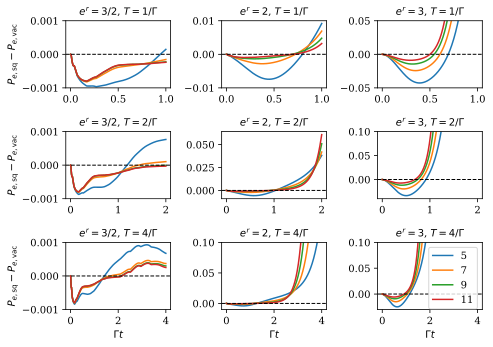

In [29]:
with plt.style.context('paper.mplstyle'):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(7, 5))

    axs[0,0].set_title(r'$e^r=3/2$, $T=1/\Gamma$')
    plot_difference(times, n_maxs[4::2], Pe_expts, vac_Pe_expt, axs[0,0])
    axs[0,0].set_ylim(-0.001, .001)

    axs[0,1].set_title(r'$e^r=2$, $T=1/\Gamma$')
    plot_difference(times, n_maxs[4::2], Pe_expts2, vac_Pe_expt, axs[0,1])
    axs[0,1].set_ylim(-0.01, .01)

    axs[0,2].set_title(r'$e^r=3$, $T=1/\Gamma$')
    plot_difference(times, n_maxs[4::2], Pe_expts3, vac_Pe_expt, axs[0,2])
    axs[0,2].set_ylim(-.05, .05)

    axs[1,0].set_title(r'$e^r=3/2$, $T=2/\Gamma$')
    plot_difference(timesT2, n_maxs[4::2], Pe_exptsT2, vac_Pe_exptT2, axs[1,0])
    axs[1,0].set_ylim(-0.001, .001)

    axs[1,1].set_title(r'$e^r=2$, $T=2/\Gamma$')
    plot_difference(timesT2, n_maxs[4::2], Pe_expts2T2, vac_Pe_exptT2, axs[1,1])

    axs[1,2].set_title(r'$e^r=3$, $T=2/\Gamma$')
    plot_difference(timesT2, n_maxs[4::2], Pe_expts3T2, vac_Pe_exptT2, axs[1,2])
    axs[1,2].set_ylim(-0.04, .1)

    axs[2,0].set_title(r'$e^r=3/2$, $T=4/\Gamma$')
    plot_difference(timesT4, n_maxs[4::2], Pe_exptsT4, vac_Pe_exptT4, axs[2,0])
    axs[2,0].set_ylim(-0.001, .001)

    axs[2,1].set_title(r'$e^r=2$, $T=4/\Gamma$')
    plot_difference(timesT4, n_maxs[4::2], Pe_expts2T4, vac_Pe_exptT4, axs[2,1])
    axs[2,1].set_ylim(-.01, .1)

    axs[2,2].set_title(r'$e^r=3$, $T=4/\Gamma$')
    plot_difference(timesT4, n_maxs[4::2], Pe_expts3T4, vac_Pe_exptT4, axs[2,2])
    axs[2,2].set_ylim(-0.03, .1)

    for ax_row in axs:
        ax_row[0].set_ylabel(r'$P_{e,\mathrm{sq}}-P_{e,\mathrm{vac}}$')
        for ax in ax_row:
            ax.axhline(0, linestyle='--', color='k', linewidth=1)
    for ax in axs[-1]:
        ax.set_xlabel(r'$\Gamma t$')
    axs[2,2].legend()
    plt.tight_layout()
    plt.savefig('vacuum-diffs.pdf', bbox_inches='tight', pad_inches=0.02)

## Sinc explorations

In [30]:
from scipy.integrate import quad

In [31]:
quad(lambda t: sinc(t)**2, -20, 20, limit=1000)

In [32]:
times_sinc = np.linspace(-10, 10, 2**13)

In [33]:
integrators_sinc = {n_max: factory.make_uncond_integrator(sinc, Id, sm, zero, np.log(2), mu)
                    for n_max, factory in factories.items()}
solns_sinc = {n_max: integrator.integrate((Id - sz)/2, times_sinc) for n_max, integrator in integrators_sinc.items()}
phys_solns_sinc = {n_max: solns_sinc[n_max].get_phys_soln(vac_rho(n_max)) for n_max in n_maxs}
Pe_expts_sinc = {n_max: phys_solns_sinc[n_max].get_expectations((Id + sz)/2) for n_max in n_maxs}

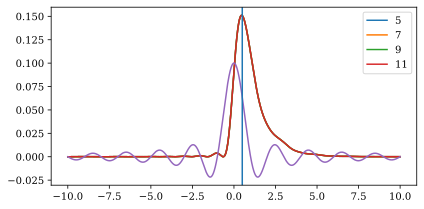

In [34]:
with plt.style.context('paper.mplstyle'):
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_Pe(times_sinc, n_maxs[4::2], Pe_expts_sinc, ax)
    plt.plot(times_sinc, 0.1*sinc(times_sinc))
    plt.axvline(0.5)
    plt.tight_layout()

    fig, ax = plt.subplots()
    plot_exp_decay(times, n_maxs, Pe_expts_sinc, vac_Pe_expt, ax)

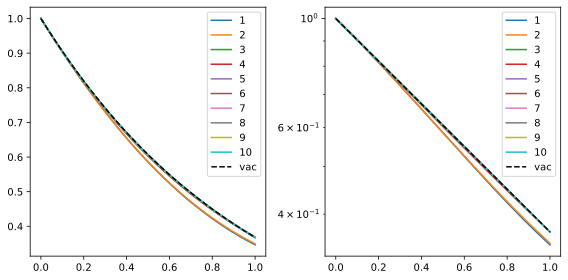

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
for n_max in n_maxs[:10]:
    axs[0].plot(times, Pe_expts[n_max], label=str(n_max))
    axs[1].semilogy(times, Pe_expts[n_max], label=str(n_max))
axs[0].plot(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[1].semilogy(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

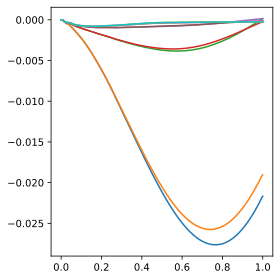

In [38]:
fig, ax = plt.subplots(figsize=(4,4))
for n_max in n_maxs[:10]:
    ax.plot(times, Pe_expts[n_max] - vac_Pe_expt, label=str(n_max))
#ax.legend()
plt.tight_layout()
plt.show()

In [39]:
xi_fn = partial(xi_rect, a=0, b=2)

In [40]:
factory = factories[1]

In [41]:
integrators = {n_max: factory.make_uncond_integrator(xi_fn, Id, sm, zero, r, mu)
              for n_max, factory in factories.items()}

In [42]:
times = np.linspace(0, 2, 2**9 + 1)

In [43]:
rho0 = (Id + sz)/2

In [44]:
field_rho0s = {n_max: sqz_rho(-r, mu, n_max) for n_max in n_maxs}

In [45]:
solns = {n_max: integrator.integrate(rho0, times) for n_max, integrator in integrators.items()}

In [46]:
Pe_expts = {n_max: solns[n_max].get_expectations((Id + sz)/2, field_rho0s[n_max]) for n_max in n_maxs}

In [47]:
vac_integrator = integ.UncondLindbladIntegrator([sm], zero)
vac_soln = vac_integrator.integrate(rho0, times)
vac_Pe_expt = vac_soln.get_expectations((Id + sz)/2)

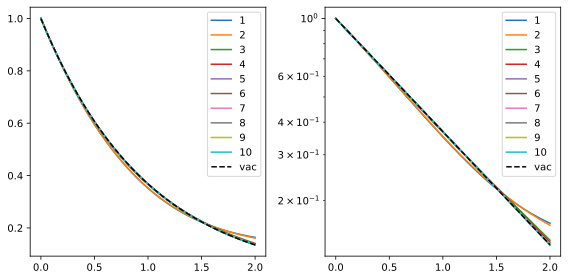

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
for n_max in n_maxs[:10]:
    axs[0].plot(times, Pe_expts[n_max], label=str(n_max))
    axs[1].semilogy(times, Pe_expts[n_max], label=str(n_max))
axs[0].plot(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[1].semilogy(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

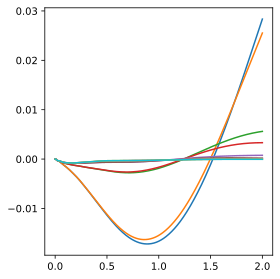

In [49]:
fig, ax = plt.subplots(figsize=(4,4))
for n_max in n_maxs[:10]:
    ax.plot(times, Pe_expts[n_max] - vac_Pe_expt, label=str(n_max))
#ax.legend()
plt.tight_layout()
plt.show()

In [50]:
xi_fn = partial(xi_rect, a=0, b=8)

In [51]:
factory = factories[1]

In [52]:
integrators = {n_max: factory.make_uncond_integrator(xi_fn, Id, sm, zero, r, mu)
              for n_max, factory in factories.items()}

In [53]:
times = np.linspace(0, 8, 8*2**8 + 1)

In [54]:
rho0 = (Id + sz)/2

In [55]:
field_rho0s = {n_max: sqz_rho(-r, mu, n_max) for n_max in n_maxs}

In [56]:
solns = {n_max: integrator.integrate(rho0, times) for n_max, integrator in integrators.items()}

In [57]:
Pe_expts = {n_max: solns[n_max].get_expectations((Id + sz)/2, field_rho0s[n_max]) for n_max in n_maxs}

In [58]:
vac_integrator = integ.UncondLindbladIntegrator([sm], zero)
vac_soln = vac_integrator.integrate(rho0, times)
vac_Pe_expt = vac_soln.get_expectations((Id + sz)/2)

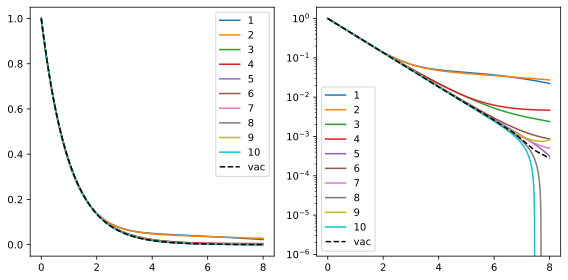

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
for n_max in n_maxs[:10]:
    axs[0].plot(times, Pe_expts[n_max], label=str(n_max))
    axs[1].semilogy(times, Pe_expts[n_max], label=str(n_max))
axs[0].plot(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[1].semilogy(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

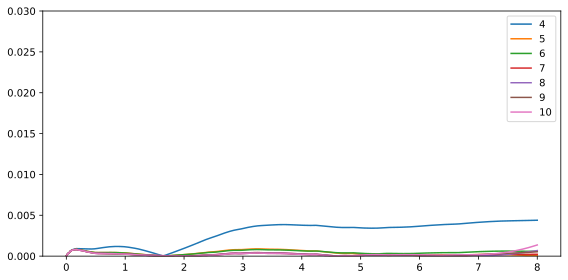

In [60]:
fig, ax = plt.subplots(figsize=(8,4))
for n_max in n_maxs[3:10]:
    ax.plot(times, np.abs(Pe_expts[n_max] - vac_Pe_expt), label=str(n_max))
ax.legend()
ax.set_ylim(0, .03)
plt.tight_layout()
plt.show()